### Run naive cell type proportion analysis

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from collections import Counter
import seaborn as sns
import scanpy as sc 
import os

from scipy.stats import spearmanr
from collections import Counter
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats

In [2]:
%%time
adata = sc.read_h5ad("../07_final_RNA_without_scvi.h5ad")
adata

CPU times: user 16.9 s, sys: 1min 14s, total: 1min 31s
Wall time: 1min 31s


AnnData object with n_obs × n_vars = 2305964 × 16115
    obs: 'age', 'donor_id', 'sex', 'region', 'cell_type', 'disease', 'consistent_cell_type', 'study', 'technology', 'cell_or_nuclei', 'barcode', 'sample_id', 'age_status', 'tech_plus_study', 'disease_binary', 'decade', 'age_group', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'scvi_cell_type', 'redo_leiden_0.5', 'UMAP1', 'UMAP2', 'v2_scvi_cell_type', 'final_cell_type'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'counts'

In [3]:
nuclei_adata = adata[adata.obs.cell_or_nuclei == "Nuclei"]
adata_metadata = nuclei_adata.obs
cell_type_key = "final_cell_type"

In [4]:
donor_level_metadata = adata_metadata[["sex", "age", "age_group", "age_status",
                                     "donor_id", "disease_binary", 
                                       "tech_plus_study"]].drop_duplicates().reset_index(drop = True)

In [5]:
donor_level_metadata['age_group'] = pd.Categorical(donor_level_metadata.age_group, 
                                                categories=["young", "fetal", "middle", "old"], 
                                                ordered=True)

In [6]:
Counter(donor_level_metadata.age_group)

Counter({'middle': 128, 'old': 101, 'young': 57, 'fetal': 13})

In [7]:
cell_type_counts_per_donor = pd.crosstab(adata_metadata['donor_id'], adata_metadata[cell_type_key])
cell_type_counts_per_donor.head()

final_cell_type,Adipocyte,Cardiomyocyte,Endocardial,Endothelial,Epicardial,Fibroblast,LEC,Lymphoid,Mast,Myeloid,Neuronal,Pericyte,vSMC
donor_id,,,,,,,,,,,,,
Chaffin 2022:P1290,0,3171,3,1566,0,969,18,359,98,953,1,1048,141
Chaffin 2022:P1300,3,2738,207,2043,1,3562,89,1505,406,2690,89,2807,1097
Chaffin 2022:P1304,65,4783,6,2326,0,8822,143,332,44,801,133,1163,413
Chaffin 2022:P1358,365,3726,23,3974,10,6406,111,1651,135,3887,173,2557,899
Chaffin 2022:P1371,148,4740,28,2205,60,3676,125,340,77,2496,89,1449,750


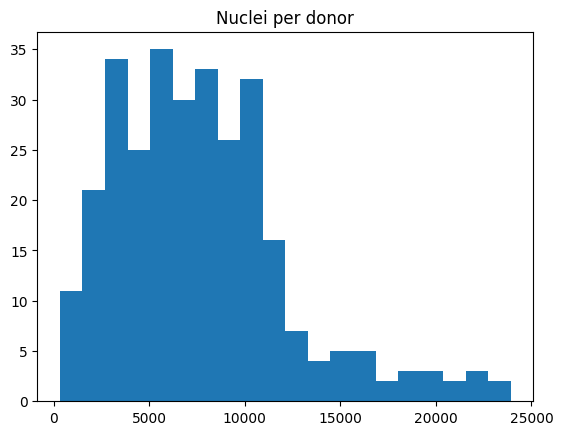

In [8]:
# save the following information for propeller
nuclei_per_donor = cell_type_counts_per_donor.sum(axis = 1)
nuclei_per_donor.to_csv("01_nuclei_per_donor.csv")
plt.hist(nuclei_per_donor, bins = 20)
plt.title("Nuclei per donor")
plt.show()

In [9]:
threshold_of_nuclei = 1000 # only analyze samples that have at least this number of cells 
print("Number of donors filtered out: " + str(np.sum(nuclei_per_donor < threshold_of_nuclei)))

donors_to_keep = (nuclei_per_donor >= threshold_of_nuclei)
filtered_cell_counts_df = cell_type_counts_per_donor.loc[donors_to_keep , :]
filtered_cell_counts_df.shape

Number of donors filtered out: 7


(292, 13)

In [10]:
filtered_donors = filtered_cell_counts_df.index

In [11]:
# normalize per donor 
norm_filtered_cell_counts_df = 100 * filtered_cell_counts_df.div(filtered_cell_counts_df.sum(axis = 1), axis = 0)

In [12]:
donor_level_metadata.index = donor_level_metadata.donor_id

In [13]:
filtered_donor_level_metadata = donor_level_metadata.loc[filtered_donors, :]
filtered_donor_level_metadata = filtered_donor_level_metadata.reset_index(drop=True)

In [14]:
# write these files for propeller later
filtered_donor_level_metadata.to_csv("01_donor_level_metadata.csv")

In [15]:
norm_filtered_cell_counts_df.to_csv("01_proportion_matrix.csv")

In [16]:
plots_dir = "plots/"
os.makedirs(plots_dir, exist_ok=True)

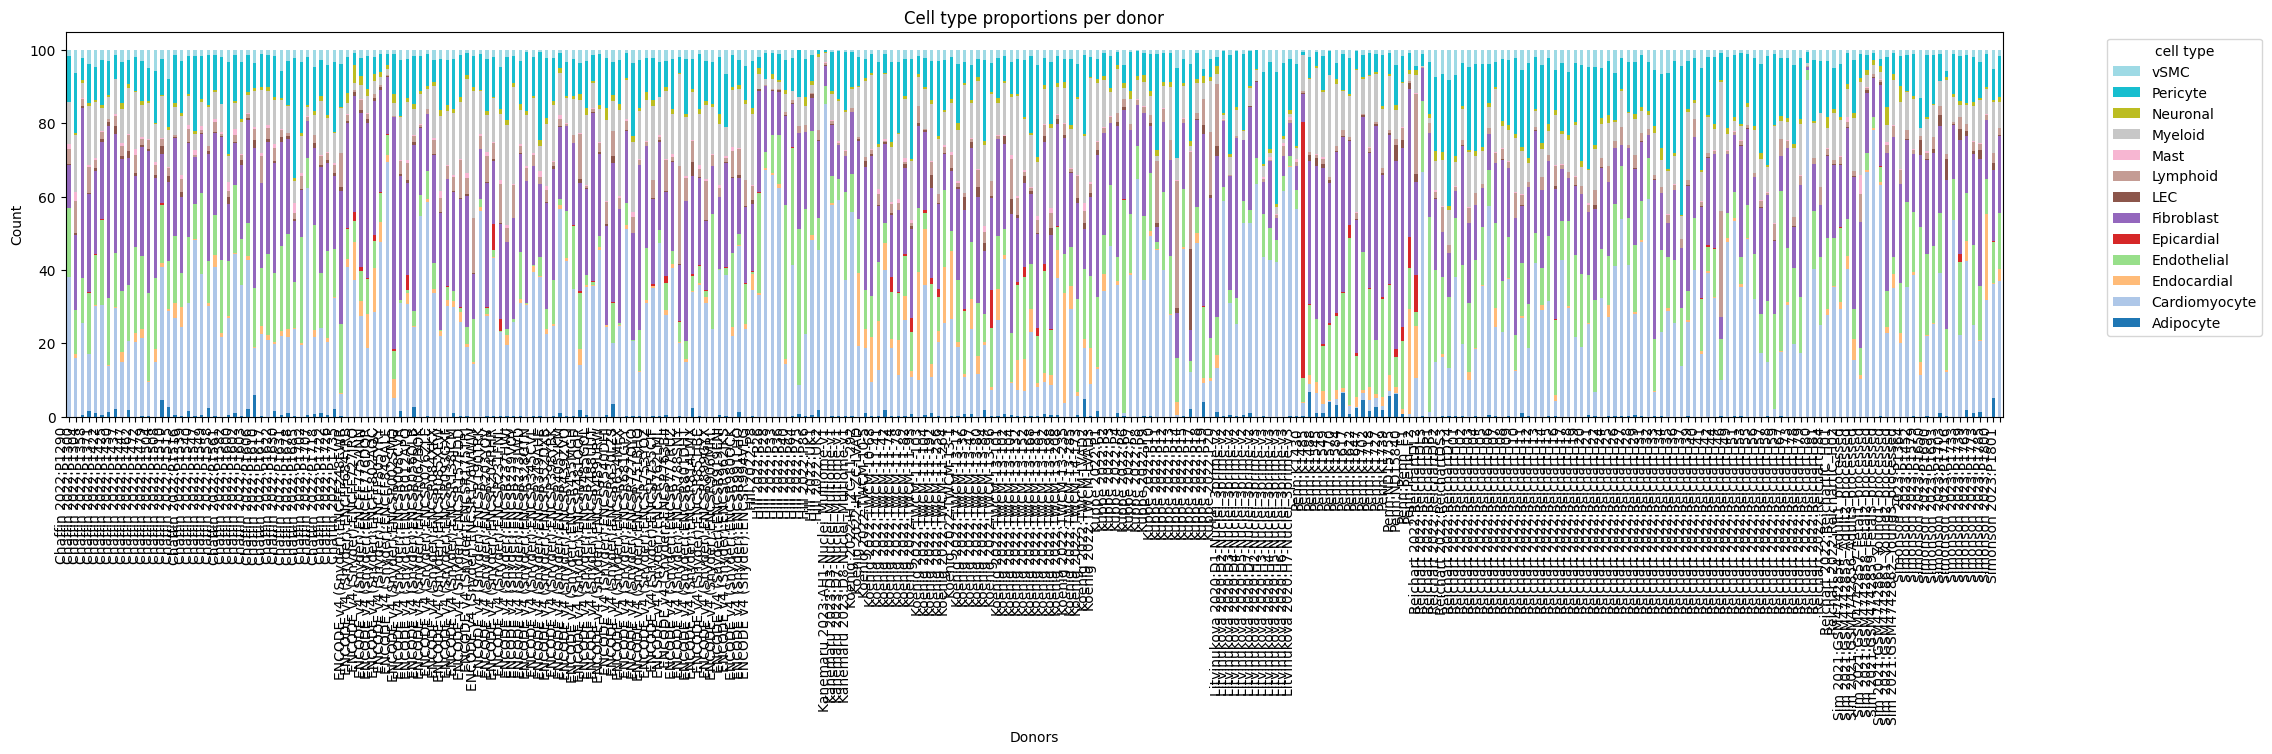

In [17]:
ax = norm_filtered_cell_counts_df.plot(kind = 'bar', stacked=True, figsize=(25, 5), colormap='tab20')
# Adding labels and title
ax.set_xlabel('Donors')
ax.set_ylabel('Count')
ax.set_title('Cell type proportions per donor')

# Reverse the legend order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='cell type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-ticks for better readability
plt.xticks(rotation=90, ha='right')
plt.savefig(plots_dir + "snRNA_cell_type_proportion_barplot.pdf")
plt.show()

### Pivot to long tidy format

In [18]:
prop_long_df = norm_filtered_cell_counts_df.reset_index().melt(id_vars = 'donor_id', 
                                                               var_name = 'cell_type', 
                                                               value_name = 'proportion').reset_index(drop = True)

In [19]:
donor_level_metadata

,sex,age,age_group,age_status,donor_id,disease_binary,tech_plus_study
donor_id,,,,,,,
Penn:Penn_F1,female,18.0,fetal,fetal,Penn:Penn_F1,N,Dropseq_Penn
Penn:Penn_F2,male,18.0,fetal,fetal,Penn:Penn_F2,N,Dropseq_Penn
ENCODE v4 (Snyder):ENCFF802AQC,male,13.0,fetal,fetal,ENCODE v4 (Snyder):ENCFF802AQC,N,Multiome-v1_ENCODE v4 (Snyder)
ENCODE v4 (Snyder):ENCFF248EWR,male,15.0,fetal,fetal,ENCODE v4 (Snyder):ENCFF248EWR,N,Multiome-v1_ENCODE v4 (Snyder)
ENCODE v4 (Snyder):ENCFF849ALE,female,16.0,fetal,fetal,ENCODE v4 (Snyder):ENCFF849ALE,N,Multiome-v1_ENCODE v4 (Snyder)
...,...,...,...,...,...,...,...
Sim 2021:GSM4742862_Young3_processed,male,14.0,young,postnatal,Sim 2021:GSM4742862_Young3_processed,N,3prime-v1_Sim 2021
Sim 2021:GSM4742860_Young1_processed,male,4.0,young,postnatal,Sim 2021:GSM4742860_Young1_processed,N,3prime-v1_Sim 2021
Sim 2021:GSM4742856_Adult3_processed,male,42.0,middle,postnatal,Sim 2021:GSM4742856_Adult3_processed,N,3prime-v1_Sim 2021


In [20]:
# merge with metadata so that we have the covariates for regression
prop_long_df = prop_long_df.merge(filtered_donor_level_metadata, on = "donor_id", how = "inner")

In [21]:
prop_long_df

,donor_id,cell_type,proportion,sex,age,age_group,age_status,disease_binary,tech_plus_study
0,Chaffin 2022:P1290,Adipocyte,0.000000,male,65.0,old,postnatal,Y,3prime-v3_Chaffin 2022
1,Chaffin 2022:P1290,Cardiomyocyte,38.080942,male,65.0,old,postnatal,Y,3prime-v3_Chaffin 2022
2,Chaffin 2022:P1290,Endocardial,0.036027,male,65.0,old,postnatal,Y,3prime-v3_Chaffin 2022
3,Chaffin 2022:P1290,Endothelial,18.806293,male,65.0,old,postnatal,Y,3prime-v3_Chaffin 2022
4,Chaffin 2022:P1290,Epicardial,0.000000,male,65.0,old,postnatal,Y,3prime-v3_Chaffin 2022
...,...,...,...,...,...,...,...,...,...
3791,Simonson 2023:P1801,Mast,0.081054,male,42.0,middle,postnatal,N,3prime-v3_Simonson 2023
3792,Simonson 2023:P1801,Myeloid,7.213779,male,42.0,middle,postnatal,N,3prime-v3_Simonson 2023
3793,Simonson 2023:P1801,Neuronal,1.215805,male,42.0,middle,postnatal,N,3prime-v3_Simonson 2023
3794,Simonson 2023:P1801,Pericyte,11.286727,male,42.0,middle,postnatal,N,3prime-v3_Simonson 2023


In [22]:
def find_proportion_outlier(prop_df):
    
    '''Identify outliers in terms of cell type proportion'''
    
    proportions = prop_df['proportion']
    first_quartile = np.quantile(proportions, q=0.25)
    third_quartile = np.quantile(proportions, q=0.75)
    IQR = third_quartile - first_quartile
    lower_range_outlier_prop = first_quartile - 1.5 * IQR
    upper_range_outlier_prop = third_quartile + 1.5 * IQR

    prop_df['is_outlier'] = False
    prop_df.loc[(prop_df['proportion'] <= lower_range_outlier_prop) | (prop_df['proportion'] >= upper_range_outlier_prop), 'is_outlier'] = True
    return(prop_df)

The regressors we will use are:
1. age
2. sex
3. disease: as a binary categorical variable
4. tech + study

In [23]:
def run_linear_regression(prop_df, method):

    y = prop_df['proportion']  # predictor variable in linear regression
    
    if method == "age":
        # one-hot encode categorical variables
        df_encoded = pd.get_dummies(prop_df, columns=['sex', 'tech_plus_study', 'disease_binary'], drop_first=True)
        X = df_encoded[['age'] + [col for col in df_encoded.columns if col.startswith('sex_') 
                                  or col.startswith('tech_plus_study_') or 
                                 col.startswith('disease_binary')] ] 
        X = X.astype(float) # make sure that the variables are numeric and not strings
    elif method == "age_group":
        df_encoded = pd.get_dummies(prop_df, columns=['age_group', 'sex', 'tech_plus_study', 'disease_binary'], drop_first=True)
        X = df_encoded[ [col for col in df_encoded.columns if col.startswith('age_group_') or
                         col.startswith('sex_') or 
                         col.startswith('tech_plus_study_') or 
                        col.startswith('disease_binary')] ]
        X = X.astype(float)
    else: 
        print("Method must either be age or age_group")
        return 1
    
    # Add a constant to the independent variables (intercept term)
    X = sm.add_constant(X)

    # Perform the regression
    model = sm.OLS(y, X).fit()

    # Print the summary of the regression results
    #print(model.summary())
    return(model)

In [24]:
unique_cell_types = prop_long_df.cell_type.unique()

### Run regression using age_group

In [25]:
age_group_models_list = list()

for cell_type_val in unique_cell_types:
    print(cell_type_val)
    cell_type_prop_df = prop_long_df[prop_long_df.cell_type == cell_type_val].copy()
    cell_type_prop_df_without_outliers = find_proportion_outlier(cell_type_prop_df)
    cell_type_prop_df_without_outliers = cell_type_prop_df_without_outliers[cell_type_prop_df_without_outliers['is_outlier'] == False]

    # keep only those that have at least 0.05%
    # this removes the samples for which none of that cell type was observed, possibly due to sampling differences
    #cell_type_prop_df_without_outliers = cell_type_prop_df_without_outliers[cell_type_prop_df_without_outliers['proportion'] > 0.05] 

    # run linear regression
    lm_model = run_linear_regression(prop_df = cell_type_prop_df_without_outliers,
                                    method = "age_group")
    age_group_models_list.append(lm_model)

Adipocyte
Cardiomyocyte
Endocardial
Endothelial
Epicardial
Fibroblast
LEC
Lymphoid
Mast
Myeloid
Neuronal
Pericyte
vSMC


In [26]:
age_group_models_list[0].params

const                                             0.032872
age_group_fetal                                  -0.149771
age_group_middle                                  0.051998
age_group_old                                     0.041158
sex_male                                          0.013845
tech_plus_study_3prime-v2_Litvinukova 2020        0.267199
tech_plus_study_3prime-v3_Chaffin 2022            0.208860
tech_plus_study_3prime-v3_Hill 2022               0.077292
tech_plus_study_3prime-v3_Kuppe 2022             -0.013668
tech_plus_study_3prime-v3_Litvinukova 2020       -0.041564
tech_plus_study_3prime-v3_Reichart 2022          -0.016172
tech_plus_study_3prime-v3_Simonson 2023           0.097542
tech_plus_study_5prime-v1_Koenig 2022             0.225570
tech_plus_study_Dropseq_Penn                      0.478831
tech_plus_study_Multiome-v1_ENCODE v4 (Snyder)    0.067002
tech_plus_study_Multiome-v1_Kanemaru 2023         0.132539
disease_binary_Y                                  0.0186

In [27]:
# from the models, extract the coefficients with .params and the pvalues with .pvalues
age_coefficients = [m.params['age_group_old'] for m in age_group_models_list]
age_p_vals = [m.pvalues['age_group_old'] for m in age_group_models_list]

fetal_coefficients = [m.params['age_group_fetal'] for m in age_group_models_list]
fetal_p_vals = [m.pvalues['age_group_fetal'] for m in age_group_models_list]

sex_coefficients = [m.params['sex_male'] for m in age_group_models_list]
sex_p_vals = [m.pvalues['sex_male'] for m in age_group_models_list]

disease_coefficients = [m.params['disease_binary_Y'] for m in age_group_models_list]
disease_p_vals = [m.pvalues['disease_binary_Y'] for m in age_group_models_list]

# create df with results
age_group_linear_reg_results_df = pd.DataFrame({'cell_type': unique_cell_types,
                                     'age_coefficient': age_coefficients,
                                     'age_p_val': age_p_vals,
                                     'sex_coefficient': sex_coefficients,
                                     'sex_p_val': sex_p_vals, 
                                     'disease_coefficient': disease_coefficients,
                                     'disease_p_val': disease_p_vals, 
                                     'fetal_coefficient': fetal_coefficients, 
                                     'fetal_p_vals': fetal_p_vals})

# perform the BH correction
_, age_p_vals_corrected, _, _ = multipletests(age_group_linear_reg_results_df['age_p_val'], alpha=0.05, method='fdr_bh')
_, sex_p_vals_corrected, _, _ = multipletests(age_group_linear_reg_results_df['sex_p_val'], alpha=0.05, method='fdr_bh')
_, disease_p_vals_corrected, _, _ = multipletests(age_group_linear_reg_results_df['disease_p_val'], alpha=0.05, method='fdr_bh')


# Add the corrected p-values to the dataframe
age_group_linear_reg_results_df['age_p_val_corrected'] = age_p_vals_corrected
age_group_linear_reg_results_df['sex_p_val_corrected'] = sex_p_vals_corrected
age_group_linear_reg_results_df['disease_p_val_corrected'] = disease_p_vals_corrected

In [28]:
age_group_linear_reg_results_df

,cell_type,age_coefficient,age_p_val,sex_coefficient,sex_p_val,disease_coefficient,disease_p_val,fetal_coefficient,fetal_p_vals,age_p_val_corrected,sex_p_val_corrected,disease_p_val_corrected
0,Adipocyte,0.041158,0.395376,0.013845,0.676219,0.018615,6.885577e-01,-0.149771,7.460474e-02,0.734903,0.732570,6.885577e-01
1,Cardiomyocyte,-1.714016,0.468782,-3.297816,0.040521,-10.978593,1.163750e-06,6.469766,1.341029e-01,0.734903,0.212116,5.042919e-06
2,Endocardial,-0.240148,0.275830,-0.256392,0.081583,-0.185536,3.641817e-01,0.889855,6.464755e-02,0.717157,0.212116,4.734362e-01
3,Endothelial,-2.647135,0.013429,-0.633551,0.375866,3.905125,1.030311e-04,-2.901964,1.223661e-01,0.174572,0.490292,3.348511e-04
4,Epicardial,0.000527,0.946339,-0.005251,0.325491,0.012021,9.675574e-02,0.025226,3.539309e-01,0.946339,0.490292,1.397583e-01
5,Fibroblast,2.949798,0.059484,2.874158,0.006969,2.777503,5.454169e-02,2.478143,3.858006e-01,0.386645,0.090599,8.863025e-02
6,LEC,0.016919,0.792245,-0.086467,0.055868,0.319445,8.626715e-07,0.453422,1.165845e-04,0.858265,0.212116,5.042919e-06
7,Lymphoid,0.136675,0.598807,-0.156399,0.377148,0.800076,8.164496e-04,-1.889813,6.734971e-05,0.734903,0.490292,2.122769e-03
8,Mast,0.022748,0.564943,-0.018666,0.480524,-0.113959,1.983510e-03,-0.188239,6.465467e-03,0.734903,0.567892,3.683662e-03
9,Myeloid,1.196688,0.172389,1.094398,0.068477,0.649254,4.308720e-01,-10.178245,2.836364e-10,0.717157,0.212116,5.092124e-01


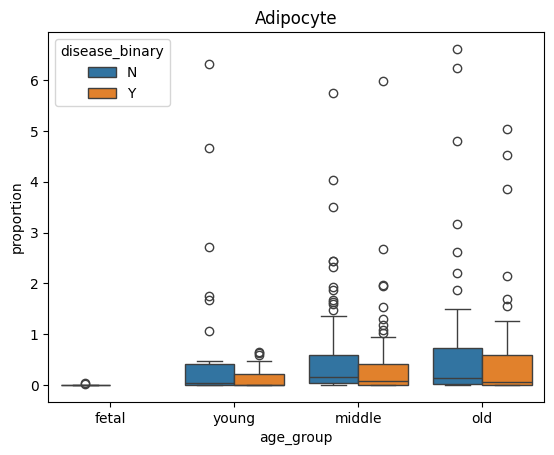

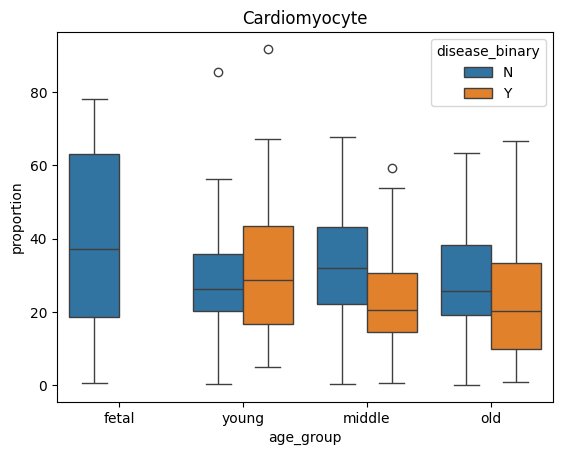

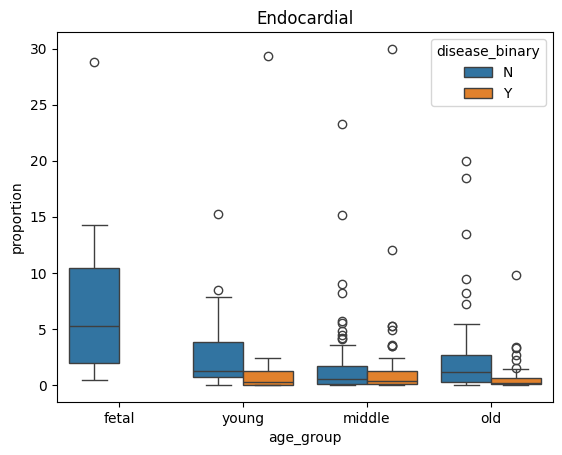

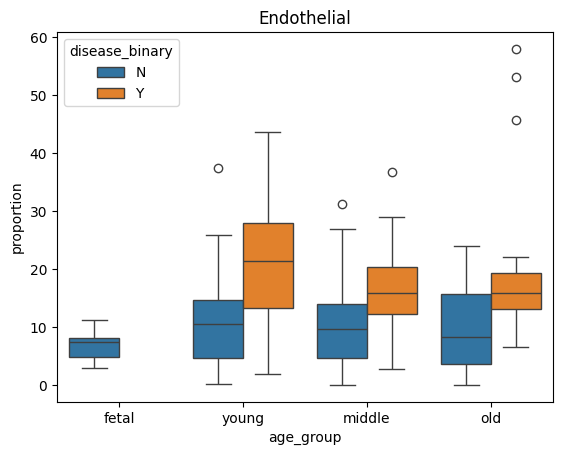

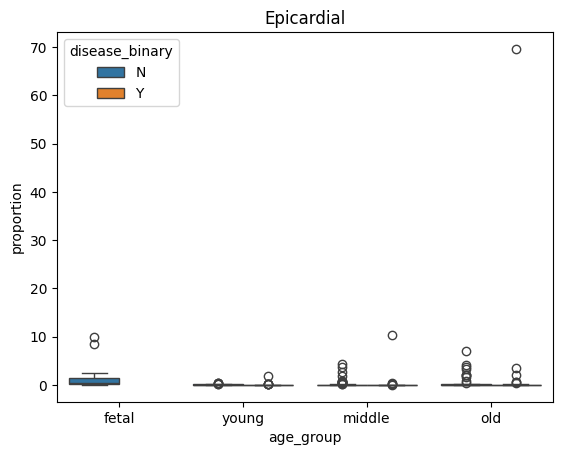

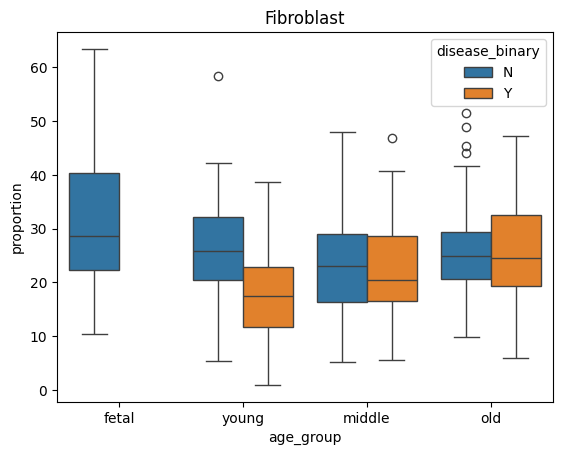

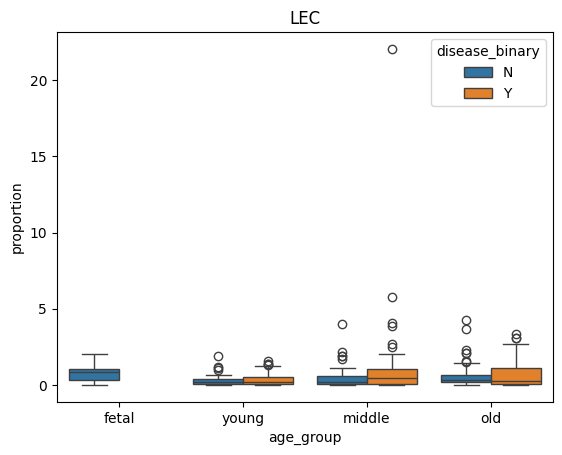

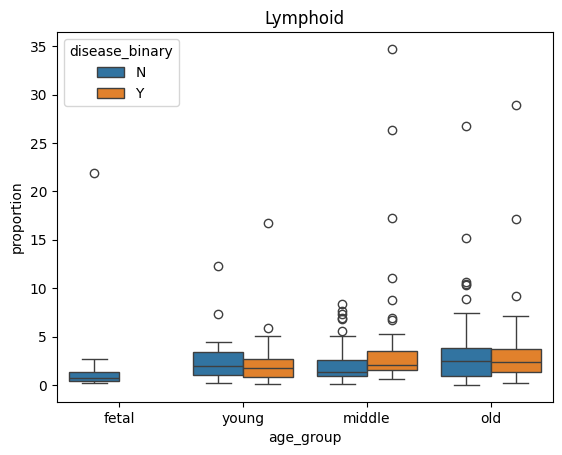

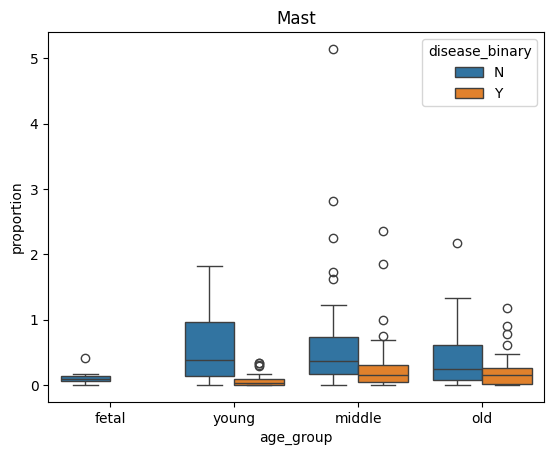

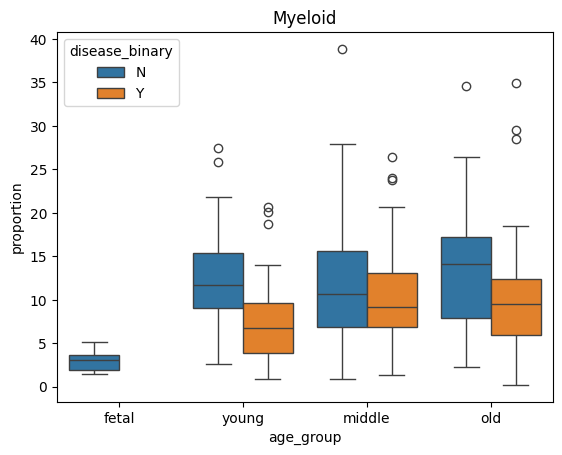

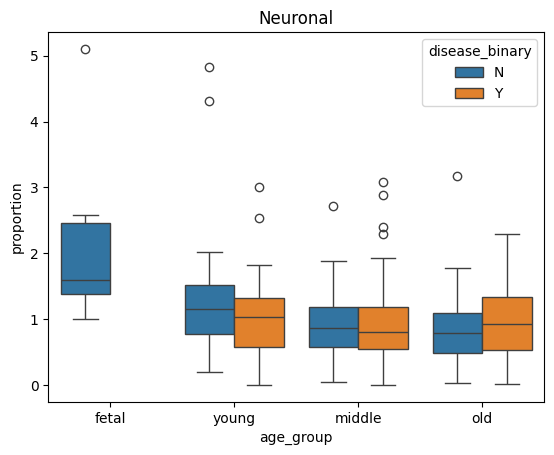

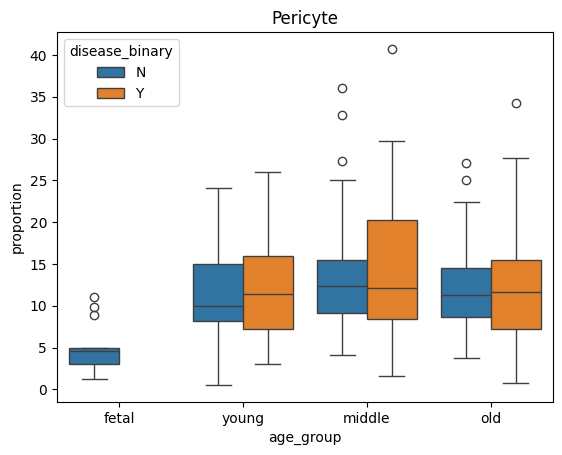

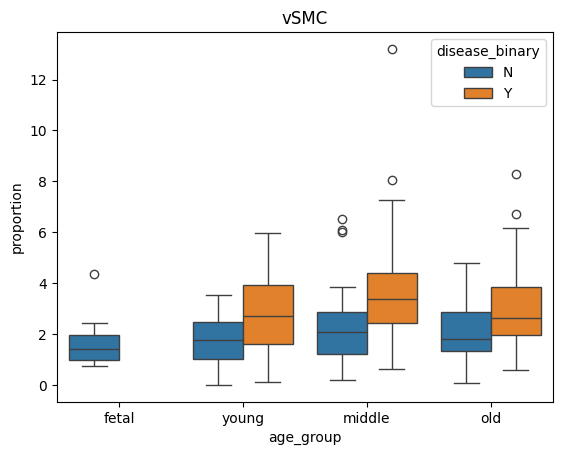

In [29]:
for cell_type_val in unique_cell_types: 
    cell_type_prop_long_df = prop_long_df[prop_long_df['cell_type'] == cell_type_val]
    sns.boxplot(data = cell_type_prop_long_df, x = 'age_group', 
                hue = 'disease_binary', y = 'proportion', order = ["fetal", "young", "middle", "old"])
    plt.title(cell_type_val)
    plt.show()